# H03e 
# A rotating Smartphone as an accelerated Frame of Reference

by:

- **Fatemeh karimi Barikarasfi (3765009)**

## 1. Experimental Setup

This experiment investigates the motion of a **rotating smartphone** as an example of an **accelerated reference frame**. The built-in **gyroscope** and **accelerometer** of a **Samsung Galaxy S23 Ultra** , with a **length of approximately 163.4 mm** and a **width of approximately 78.1 mm**, were used to record the components of **angular velocity** and **acceleration** while the phone rotated on a horizontal surface.

To reduce friction and ensure smooth rotation, a **small round magnet** was attached to the back of the smartphone. This provided a smooth, low-friction contact with the surface and prevented scratches.

The smartphone was rotated about the **vertical (z) axis**, approximately through its center. The **Phyphox** app was used to record  
- **angular velocity** components $(\omega_x, \omega_y, \omega_z)$ in $rad/s$, and  
- **acceleration components** $(a_x, a_y, a_z)$ or **linear acceleration** (without $\mathbf{g}$) in $m/s²$.  

The coordinate system follows the standard smartphone convention:  
- The **x-axis** points to the right side of the phone,  
- The **y-axis** points upward along the screen,  
- The **z-axis** points outward, perpendicular to the display.

During rotation, the phone represents a **non-inertial frame**. In addition to gravity $\mathbf{g}$, the accelerometer measures the fictitious accelerations:

$$
\mathbf{a} = \mathbf{g} - \boldsymbol{\omega}\times(\boldsymbol{\omega}\times\mathbf{r}) - \boldsymbol{\alpha}\times\mathbf{r},
$$

where $\boldsymbol{\omega}$ is the angular velocity, $\boldsymbol{\alpha}$ the angular acceleration, and $\mathbf{r}$ the position of the sensor.  
After subtracting $\mathbf{g}$, the **linear acceleration** used for further analysis is:

$$
\mathbf{a}_{\text{lin}} = -\boldsymbol{\omega}\times(\boldsymbol{\omega}\times\mathbf{r}) - \boldsymbol{\alpha}\times\mathbf{r}.
$$

<p><img src="./asset/5764743399079611361.jpg" width="400" alt/></p>
<p><em>the Smartphone used in experiment</em></p>

## 2. Physical Background

For rotation about the **z-axis**,  
$\boldsymbol{\omega} = (0, 0, \omega_z)$, $\boldsymbol{\alpha} = (0, 0, \alpha_z)$, $\mathbf{r} = (x, y, 0)$.

The linear acceleration components are then:

$$
\boxed{
\begin{aligned}
a_x &= -\omega_z^2 x + \alpha_z y, \\
a_y &= -\omega_z^2 y - \alpha_z x.
\end{aligned}
}
$$

Here, the first term ($\omega_z^2$) corresponds to the **centrifugal acceleration**, and the second term ($\alpha_z$) to the **Euler acceleration**.  
These equations connect the measured accelerations $(a_x, a_y)$ to the angular velocity $\omega_z$, angular acceleration $\alpha_z$, and the unknown sensor coordinates $(x, y)$.  
They serve as the basis for **curve fitting** and **symbolic regression** to determine the sensor position.

## 3. Data Analysis and Programming

The following sections are dedicated to the **data analysis** and **computational processing** of the recorded measurements. 


### Data Preparation and Importing Sensor Data

In this section, the required Python libraries are imported for initial data handling and visualization.  
Further libraries specific to later analyses (such as curve fitting, regression, and symbolic modeling) will be imported in their corresponding sections.


In [1]:
# Importing needed libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter


In [2]:
# Loading data
gyroscope = pd.read_csv('./data/Gyroscope.csv')
accelerometer = pd.read_csv('./data/Accelerometer.csv')
linear_acceleration = pd.read_csv('./data/Linear Acceleration.csv')

# The following columns from the data will be used for computation
t = gyroscope['Time (s)'].to_numpy()
w_z = gyroscope['Gyroscope z (rad/s)'].to_numpy()
a_x = accelerometer['Acceleration x (m/s^2)'].to_numpy()[:t.shape[0]]
a_y = accelerometer['Acceleration y (m/s^2)'].to_numpy()[:t.shape[0]]

### Visualization of Sensor Data

This section visualizes the recorded data from all three sensors — **gyroscope**, **accelerometer**, and **linear acceleration** — as functions of time.


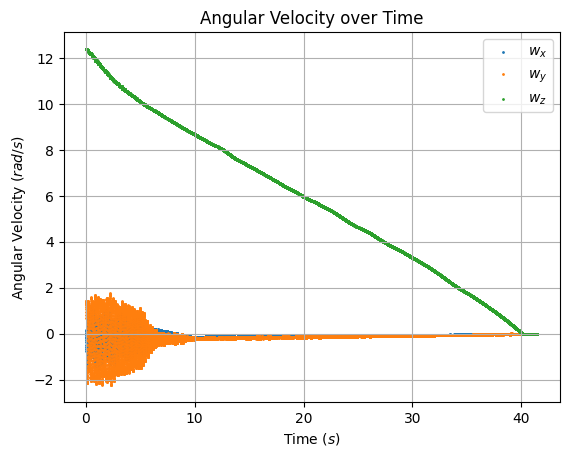

In [3]:
plt.figure()
plt.title('Angular Velocity over Time')
plt.scatter(t, gyroscope['Gyroscope x (rad/s)'], s=1, label='$w_x$')
plt.scatter(t, gyroscope['Gyroscope y (rad/s)'], s=1, label='$w_y$')
plt.scatter(t, gyroscope['Gyroscope z (rad/s)'], s=1, label='$w_z$')
plt.xlabel('Time $(s)$')
plt.ylabel('Angular Velocity $(rad/s)$')
plt.legend()
plt.grid(True)
plt.show()

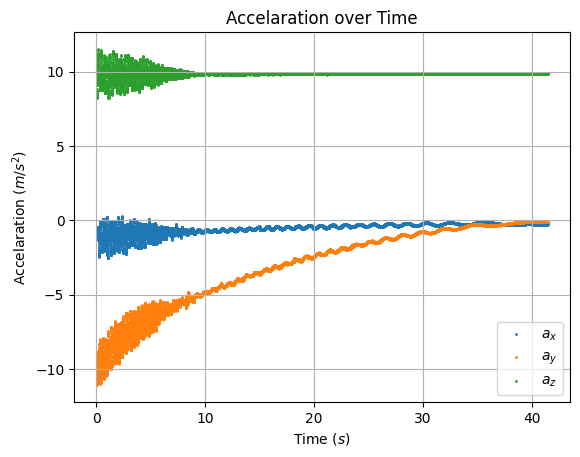

In [4]:
plt.figure()
plt.title('Accelaration over Time')
plt.scatter(accelerometer['Time (s)'], accelerometer['Acceleration x (m/s^2)'], s=1, label='$a_x$')
plt.scatter(accelerometer['Time (s)'], accelerometer['Acceleration y (m/s^2)'], s=1, label='$a_y$')
plt.scatter(accelerometer['Time (s)'], accelerometer['Acceleration z (m/s^2)'], s=1, label='$a_z$')
plt.xlabel('Time $(s)$')
plt.ylabel('Accelaration $(m/s^2)$')
plt.legend()
plt.grid(True)
plt.show()

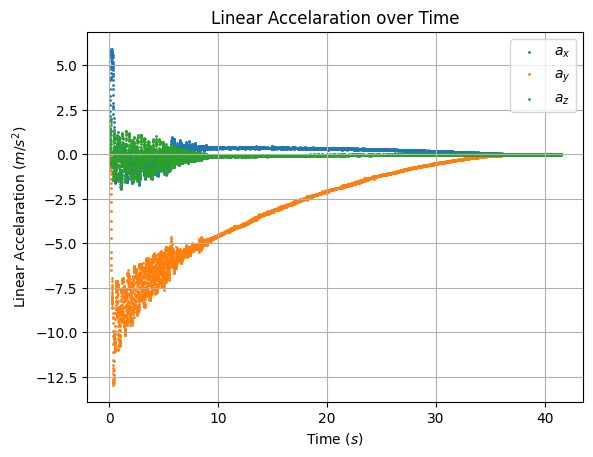

In [5]:
plt.figure()
plt.title('Linear Accelaration over Time')
plt.scatter(linear_acceleration['Time (s)'], linear_acceleration['Linear Acceleration x (m/s^2)'], s=1, label='$a_x$')
plt.scatter(linear_acceleration['Time (s)'], linear_acceleration['Linear Acceleration y (m/s^2)'], s=1, label='$a_y$')
plt.scatter(linear_acceleration['Time (s)'], linear_acceleration['Linear Acceleration z (m/s^2)'], s=1, label='$a_z$')
plt.xlabel('Time $(s)$')
plt.ylabel('Linear Accelaration $(m/s^2)$')
plt.legend()
plt.grid(True)

plt.show()

### Data Smoothing

Since raw sensor data are noisy, a **Savitzky–Golay filter** is applied to smooth the angular velocity and acceleration components.

This method preserves the general shape of the signals while reducing random fluctuations.  
The smoothed $\omega_z$ is later differentiated to obtain the angular acceleration $\alpha_z(t)$.

Care must be taken in selecting the window size:
- Too small → still noisy  
- Too large → over-smoothing and loss of detail


In [6]:
# Smoothing
## Since data is noisy, 
w_z_smooth = savgol_filter(w_z, window_length=25, polyorder=5)
a_x_smooth = savgol_filter(a_x, window_length=25, polyorder=5)
a_y_smooth = savgol_filter(a_y, window_length=25, polyorder=5)

w_z_2 = w_z_smooth ** 2
alpha = np.append(np.diff(w_z_smooth, 1) / np.diff(t, 1), 0)
alpha_z = np.append(np.diff(w_z, 1) / np.diff(t, 1), 0)
X = np.array([w_z_2, alpha]).T
Y = np.array([a_x_smooth, a_y_smooth]).T

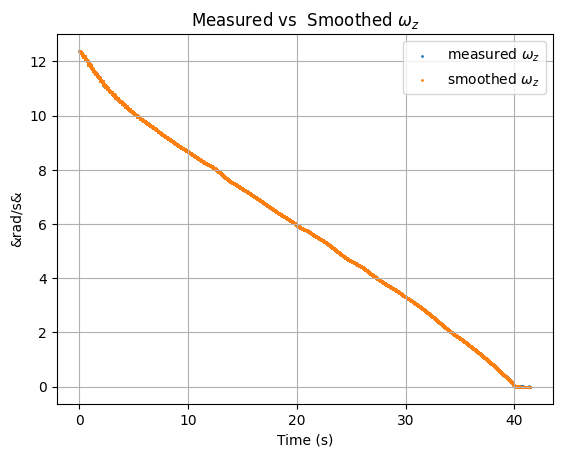

In [7]:
plt.figure()
plt.scatter(t, w_z, s=1, label='measured $\\omega_z$')
plt.scatter(t, w_z_smooth, s=1, label='smoothed $\\omega_z$')
plt.xlabel('Time (s)')
plt.ylabel('&rad/s&')
plt.title('Measured vs  Smoothed $\\omega_z$')
plt.legend()
plt.grid(True)
plt.show()

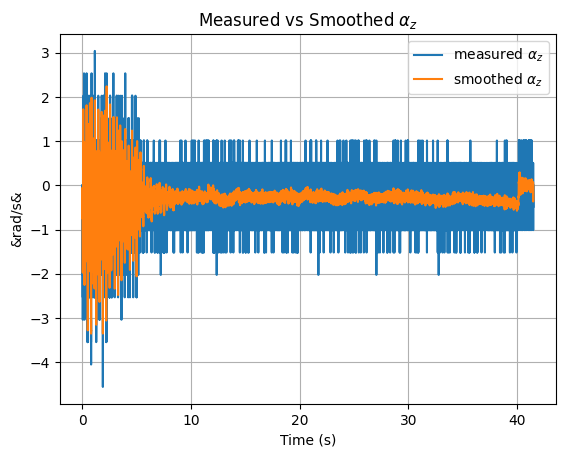

In [8]:
plt.figure()
plt.plot(t, alpha_z, label='measured $\\alpha_z$')
plt.plot(t, alpha, label='smoothed $\\alpha_z$')
plt.xlabel('Time (s)')
plt.ylabel('&rad/s&')
plt.title('Measured vs Smoothed $\\alpha_z$')
plt.legend()
plt.grid(True)
plt.show()

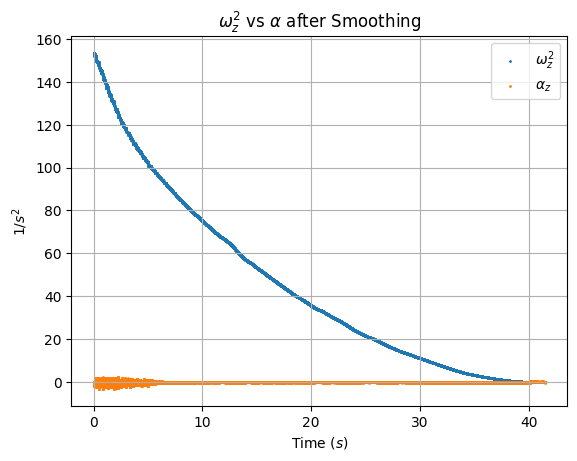

In [9]:
plt.figure()
plt.title('$\\omega_z^2$ vs $\\alpha$ after Smoothing')
plt.scatter(t, w_z_2, s=1, label='$\\omega_z^2$')
plt.scatter(t, alpha, s=1, label='$\\alpha_z$')
plt.xlabel('Time ($s$)')
plt.ylabel('$1/s^2$')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Plot function which is used in next steps several times
def plot_all(a_x_real, a_y_real, a_x_pred, a_y_pred, formula_x=None, formula_y=None):
    plt.figure()
    plt.plot(t, a_x_real, label='measured $a_x$')
    plt.plot(t, a_x_pred, c='orange', label='predicted $a_x$')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Time ($s$)')
    plt.ylabel('$a_x (m/s^2)$')
    if formula_x is not None:
        plt.text(0.6, 0.3, formula_x, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",  facecolor='wheat', alpha=0.6))
    plt.show()

    plt.figure()
    plt.plot(t, a_y_real, label='measured $a_y$')
    plt.plot(t, a_y_pred, c='orange', label='predicted $a_y$')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Time ($s$)')
    plt.ylabel('$a_y (m/s^2)$')
    if formula_y is not None:
        plt.text(0.6, 0.3, formula_y, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",  facecolor='wheat', alpha=0.6))
    elif formula_x is not None:
        plt.text(0.6, 0.3, formula_x, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",  facecolor='wheat', alpha=0.6))
    plt.show()

### Curve Fitting (Task 3)

Curve fitting is performed using `scipy.optimize.curve_fit` to determine the coordinates $(x, y)$ of the acceleration sensor.

The theoretical relations used are:
$$
\begin{aligned}
a_x &= -\omega_z^2 x + \alpha_z y, \\
a_y &= -\omega_z^2 y - \alpha_z x.
\end{aligned}
$$

Here:
- $\omega_z$ and $\alpha_z$ are obtained from the gyroscope data,  
- $(a_x, a_y)$ are taken from the acceleration data.

The fitting procedure minimizes the difference between measured and predicted accelerations.  
The resulting $(x, y)$ values represent the sensor’s position relative to the rotation center, including uncertainties.


In [11]:
# Curve Fitting
from scipy.optimize import curve_fit

def f(X, x, y):
    omega_2 = X[:, 0]
    alpha = X[:, 1]

    ax = -omega_2 * x - alpha * y
    ay = -omega_2 * y + alpha * x

    return np.concatenate(np.array([ax, ay]).T)

opts, cov = curve_fit(f, X, np.concatenate(Y))

Y_pred = np.reshape(f(X, *opts), (-1, 2))

a_x_pred = Y_pred[:, 0]
a_y_pred = Y_pred[:, 1]


x, y = opts

# Compute standard deviation (uncertainty) from covariance matrix
x_std = np.sqrt(cov[0, 0])
y_std = np.sqrt(cov[1, 1])


from the curve fitting, the coordinates of the acceleration sensor were obtained as:

In [12]:
from IPython.display import Latex
Latex(f"""
$
r_x = {x*100:.3f} ± {x_std*100:.3f} cm \\\\
r_y = {y*100:.3f} ± {y_std*100:.3f} cm
$
""")

<IPython.core.display.Latex object>

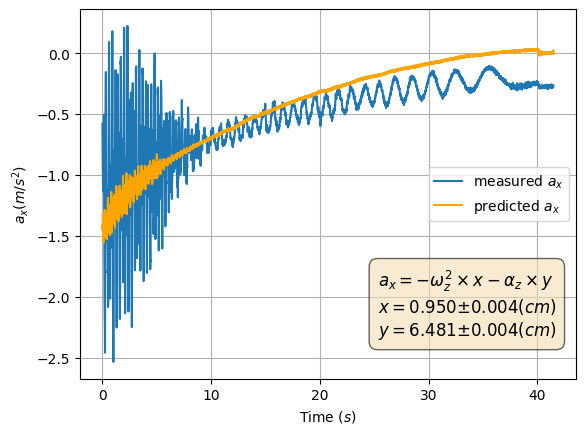

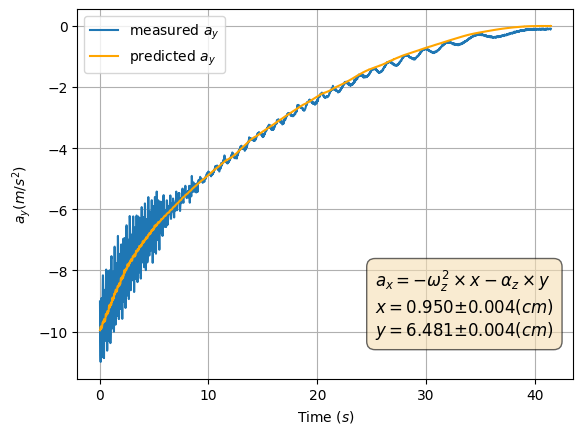

In [13]:
formula = r'$a_x = - \omega_z^2 \times x - \alpha_z \times y$' + '\n' + f'$x = {x*100:.3f} ± {x_std*100:.3f} (cm)$' + '\n' + f'$y = {y*100:.3f} ± {y_std*100:.3f} (cm)$'
plot_all(a_x_smooth, a_y_smooth, a_x_pred, a_y_pred, formula)

### Symbolic Regression (Task 4)

In this step, **symbolic regression** using `gplearn` automatically searches for mathematical expressions that describe the relationship between $(\omega_z, \alpha_z)$ and $(a_x, a_y)$.

Unlike numerical regression, symbolic regression returns **explicit formulas** composed of arithmetic operations that best fit the data.

The final symbolic expressions are converted into human-readable form using **SymPy** and compared with the theoretical model:

$$
a_x = -\omega_z^2 x + \alpha_z y \\

a_y = -\omega_z^2 y - \alpha_z x.
$$

If the resulting symbolic expressions approximate these forms, the regression successfully rediscovered the physical relationships from the data.


In [14]:
# Symbolic Regression
from gplearn.genetic import SymbolicRegressor
from sympy import *

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x    : 1/x,
    'sqrt': lambda x   : x**0.5
}

args = {
    'population_size': 2000,
    'generations': 30,
    'stopping_criteria': 1e-6,
    'function_set': ("add", "sub", "mul"),
    'feature_names': ["ω_z^2", "α_z"],
    'parsimony_coefficient': 1e-4,
    'max_samples': 0.9,
    'p_crossover': 0.7,
    'p_subtree_mutation': 0.15,
    'p_hoist_mutation': 0.05,
    'p_point_mutation': 0.1,
    'verbose': 1,
    'random_state': 123,
    'n_jobs': -1,
}

model1 = SymbolicRegressor(**args)
model1.fit(X, Y[:, 0])

model2 = SymbolicRegressor(**args)
model2.fit(X, Y[:, 1])

a_x_pred = model1.predict(X)
a_y_pred = model2.predict(X)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    35.01      2.60402e+19       31         0.185057         0.191944      2.77m
   1    12.46      1.03334e+10       11         0.177391         0.181325      1.02m
   2     8.79          55576.5       15         0.174627         0.174711     53.17s
   3    16.42      2.01269e+09       13         0.163309         0.161525     57.59s
   4    35.12      3.02998e+06       13         0.162902         0.165194     59.56s
   5    23.81          4644.44       17         0.160779         0.178136      1.01m
   6    15.22      1.29638e+11       17         0.126112         0.132268     53.71s
   7    15.63          50741.2       17         0.126489          0.12887     49.38s
   8    16.64           103773       17         0.125545         0.137362  

Symbolic regression produced the following approximate expressions:

In [15]:
def round_expr(expr, n):
    return expr.xreplace({f: N(f, n) for f in expr.atoms() if f.is_Float})
    
from IPython.display import Latex
Latex(f"""$
a_x = {latex(round_expr(sympify(str(model1._program),locals=converter), 4))}\\\\
a_y = {latex(round_expr(sympify(str(model2._program),locals=converter), 4))}
$""")

<IPython.core.display.Latex object>

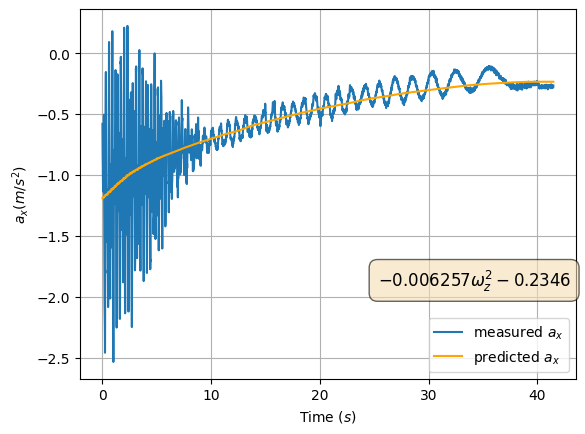

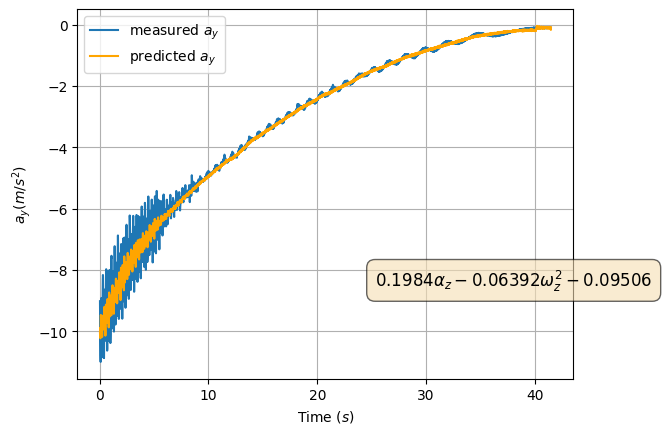

In [16]:
formula_x = latex(round_expr(sympify(str(model1._program),locals=converter), 4), mode='inline')
formula_y = latex(round_expr(sympify(str(model2._program),locals=converter), 4), mode='inline')
plot_all(a_x_smooth, a_y_smooth, a_x_pred, a_y_pred, formula_x, formula_y)

***Interpretation of Symbolic Regression***

The symbolic regression did not reproduce the theoretical equations for
$(a_x, a_y)$ as expected from the physical model.  
Instead, it generated more complex or incomplete expressions that only partially
represent the dependence on $\omega_z$ and $\alpha_z$.

The main reason for this deviation lies in the **experimental data quality** and the
**non-ideal motion conditions** during measurement:

1. **Non-ideal rotation:**  
   The smartphone did not rotate perfectly around a single vertical axis and experienced
   slight **sliding and wobbling** on the surface.  
   Consequently, the motion was not a pure rotation about the z-axis; it included small
   contributions from $\omega_x$ and $\omega_y$.  
   These irregularities introduced additional components to the measured acceleration,
   making the data deviate from the ideal centrifugal and Euler acceleration model.

2. **Sampling mismatch:**  
   The **sampling rates** of the gyroscope and accelerometer were not exactly identical,
   and the corresponding data samples were recorded with a small **time offset**.  
   This desynchronization caused $\omega_z$, $\alpha_z$, and $(a_x, a_y)$ to lose perfect
   temporal alignment, which significantly affects regression and fitting accuracy.

3. **Noise and limited data window:**  
   The measured data include sensor noise and slight non-uniformities in rotation speed.
   Moreover, the duration of stable rotation was relatively short, which limited the
   amount of usable, high-quality data for regression.

Because of these combined effects, the regression algorithm was unable to rediscover
the exact analytical form of the theoretical relations
